Qingchen Tang Z5183977
# Part 1 Topic Classiﬁcation

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import itertools
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer,WordNetLemmatizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS,CountVectorizer
from sklearn.model_selection import cross_val_predict,cross_val_score,cross_validate
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

In [2]:
# Check the Data
df = pd.read_csv('dataset.tsv', sep='\t')
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
df

Shape: (1500, 6)
Columns: ['artist_name', 'track_name', 'release_date', 'genre', 'lyrics', 'topic']


,artist_name,track_name,release_date,genre,lyrics,topic
0,loving,the not real lake,2016,rock,awake know go see time clear world mirror worl...,dark
1,incubus,into the summer,2019,rock,shouldn summer pretty build spill ready overfl...,lifestyle
2,reignwolf,hardcore,2016,blues,lose deep catch breath think say try break wal...,sadness
3,tedeschi trucks band,anyhow,2016,blues,run bitter taste take rest feel anchor soul pl...,sadness
4,lukas nelson and promise of the real,if i started over,2017,blues,think think different set apart sober mind sym...,dark
...,...,...,...,...,...,...
1495,ra ra riot,absolutely,2016,rock,year absolutely absolutely absolutely crush ab...,emotion
1496,mat kearney,face to face,2018,rock,breakthrough hours hear truth moments trade fa...,dark
1497,owane,born in space,2018,jazz,look look right catch blue eye own state breat...,dark
1498,nappy roots,blowin' trees,2019,hip hop,nappy root gotta alright flyin dear leave lone...,personal


In [3]:
# Label Check: Topic
topic_count = df['topic'].value_counts()
topic_count

topic
dark         490
sadness      376
personal     347
lifestyle    205
emotion       82
Name: count, dtype: int64


## Part 1.1


(i) The regex in the tutorial is too simple and directly removes all non-letter, number, and space characters. But unlike the news, music data contains a large number of special expressions and symbols, such as words with apostrophes or hyphens (rock'n'roll and hip-hop), as well as frequent abbreviations (don't, can't, I'm, etc.) and emotional punctuation (!, ?) . These contents may have an important impact on semantic understanding and model performance. Therefore, I plan to use a more flexible approach for regex processing, try to keep meaningful special characters, and replace some symbols with Spaces instead of removing them directly, and further optimize the preprocessing based on the performance of the model.

(ii) The evaluation methods in the tutorial are based on only a single train-test split, which makes the evaluation results highly dependent on a single random split and lacks stability and representation. At the same time, by the preliminary observation of the dataset, it can be seen that the class distribution is obviously unbalanced, and a single division may lead to some classes being underestimated or omitted in the validation set. I will use Stratified K-Fold Cross-Validation in future experiments to improve the reliability of model evaluation and ensure that each class is adequately and evenly covered.


## Part 1.2
In this part, I use Multinomial Naive Bayes (MNB) model to compare the performance of several text preprocessing strategies on the task of music topic classification. 

Specifically, strategies include whether to remove special characters (remove_special_chars), regular expression patterns (regex), removal strategy (strategy), lowercase, stop word removal (stp), stop word sources (stp_s), and stemming or stemming.

I evaluated the classification performance of the MNB model using five-fold cross validation by looping over all possible combinations of text preprocessing strategies, as shown in the following code and results:

In [4]:
# Concatenate all features
df['Content'] = (
    df['artist_name'].astype(str) + ' ' +
    df['track_name'].astype(str) + ' ' +
    df['release_date'].astype(str) + ' ' +
    df['genre'].astype(str) + ' ' +
    df['lyrics'].astype(str)
)
df = df[['Content', 'topic']]

# Drop duplicates and missing values
df = df.drop_duplicates()
df = df.dropna()

df

,Content,topic
0,loving the not real lake 2016 rock awake know ...,dark
1,incubus into the summer 2019 rock shouldn summ...,lifestyle
2,reignwolf hardcore 2016 blues lose deep catch ...,sadness
3,tedeschi trucks band anyhow 2016 blues run bit...,sadness
4,lukas nelson and promise of the real if i star...,dark
...,...,...
1495,ra ra riot absolutely 2016 rock year absolutel...,emotion
1496,mat kearney face to face 2018 rock breakthroug...,dark
1497,owane born in space 2018 jazz look look right ...,dark
1498,nappy roots blowin' trees 2019 hip hop nappy r...,personal


In [5]:
# Download NLTK
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aufb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Aufb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Aufb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Aufb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
def preprocess_text(text,
                    remove_special_chars=True,
                    regex=r'[^\w\s]',
                    strategy='remove',     # 'remove' or 'replace_space'
                    lowercase=True,
                    stp=True,
                    stp_s='nltk', # 'nltk' or 'sklearn'
                    stemming='none'       # 'porter', 'lemma', or 'none'
):
    if lowercase:
        text = text.lower()
        
    if remove_special_chars: # Handle special characters
        if strategy == 'replace_space':# Replace with Spaces
            text = re.sub(regex, ' ', text)
        else:  # remove
            text = re.sub(regex, '', text)
    text = re.sub(r'\s+', ' ', text).strip() # Clear out redundant Spaces
    
    tokens = word_tokenize(text)
    
    if stp: # Get stop words
        if stp_s == 'nltk':
            stp_words = set(stopwords.words('english'))
        else:  # sklearn
            stp_words = ENGLISH_STOP_WORDS
    
    if stemming == 'porter': # Initialize the stem extractor
        ps = PorterStemmer()
    elif stemming == 'lemma':
        lemmatizer = WordNetLemmatizer()
    if stp:
        tokens = [word for word in tokens if word not in stp_words] 

    if stemming== 'porter': # Stem extraction 
        tokens = [ps.stem(token) for token in tokens]
    elif stemming== 'lemma':
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

In [7]:
remove_special_chars=[True,False]
regex = [r"[^\w\s]",r"[^\w\s']",r"[^\w\s'-]",r"[^\w\s'!?]",r"[^\w\s'!?-]",r"[^\w\s'!?.]"]
strategy=['remove','replace_space']
lowercase=[True,False]
stp=[True,False]
stp_s=['nltk' , 'sklearn']
stemming=['porter', 'lemma', 'none']

param_grid = list(itertools.product(remove_special_chars, regex, strategy, lowercase, stp, stp_s, stemming))

best_mean = 0
best_std = None
best_col = None
best_params = None

# Test all strategies
for idx, params in enumerate(param_grid):
    rsc, rx, stg, low, stpw, stpw_s, stm = params
    col_name = f'Content_pro'

    df[col_name] = df['Content'].apply(lambda x:
        preprocess_text(
            x,
            remove_special_chars=rsc,
            regex=rx,
            strategy=stg,
            lowercase=low,
            stp=stpw,
            stp_s=stpw_s,
            stemming=stm
        )
    )

    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df[col_name])
    y = df['topic']
    mnb = MultinomialNB()
    scores = cross_val_score(mnb, X, y, cv=5, scoring='accuracy')
    mean_acc = scores.mean()
    std_acc = scores.std()

    print(f"{idx} Acc:{mean_acc:.4f}, Params: {str(params)}")

    if mean_acc > best_mean:
        best_mean = mean_acc
        best_std = std_acc
        best_col = col_name
        best_params = params

print("\nBest combination: {} | Mean Accuracy: {:.4f} | Std: {:.4f}".format(
    best_col, best_mean, best_std
))
print("Best params:", best_params)

0 Acc:0.7858, Params: (True, '[^\\w\\s]', 'remove', True, True, 'nltk', 'porter')
1 Acc:0.7905, Params: (True, '[^\\w\\s]', 'remove', True, True, 'nltk', 'lemma')
2 Acc:0.7912, Params: (True, '[^\\w\\s]', 'remove', True, True, 'nltk', 'none')
3 Acc:0.7811, Params: (True, '[^\\w\\s]', 'remove', True, True, 'sklearn', 'porter')
4 Acc:0.7784, Params: (True, '[^\\w\\s]', 'remove', True, True, 'sklearn', 'lemma')
5 Acc:0.7811, Params: (True, '[^\\w\\s]', 'remove', True, True, 'sklearn', 'none')
6 Acc:0.7845, Params: (True, '[^\\w\\s]', 'remove', True, False, 'nltk', 'porter')
7 Acc:0.7912, Params: (True, '[^\\w\\s]', 'remove', True, False, 'nltk', 'lemma')
8 Acc:0.7892, Params: (True, '[^\\w\\s]', 'remove', True, False, 'nltk', 'none')
9 Acc:0.7845, Params: (True, '[^\\w\\s]', 'remove', True, False, 'sklearn', 'porter')
10 Acc:0.7912, Params: (True, '[^\\w\\s]', 'remove', True, False, 'sklearn', 'lemma')
11 Acc:0.7892, Params: (True, '[^\\w\\s]', 'remove', True, False, 'sklearn', 'none')
12

After testing all combinations of text preprocessing parameters, the best solution was as follows: remove_special_chars=True (removes special characters ); regex retain only letters, numbers, spaces and hyphens, while removing all other characters; strategy='remove' (removes matched special characters directly), lowercase=True (convert all text to lowercase), stp=False (do not remove stopwords), and stemming='lemma' (apply  lemma). Under 5-fold cross validation, the average accuracy of this preprocessing scheme is 0.7912.

The setting of regex has a negligible impact on the model performance. This is because there are almost no special characters in the entire file. At the same time, not removing stop words can help distinguish different themes in the context of music, because a large number of high-frequency "stop words" may carry emotional, structural, or thematic cues (e.g., "I", "you", "we", etc.) in the lyrics. Lemmatization further normalizes different word forms, reduces feature sparsity and improves classification performance.

## Part 1.3

In [8]:
df['Content_pro'] = df['Content'].apply(lambda x: 
    preprocess_text(x, remove_special_chars=True, regex=r"[^\w\s'-]", strategy='remove',
                    lowercase=True, stp=False, stemming='lemma')
)
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['Content_pro'])
y = df['topic']

mnb = MultinomialNB()
bnb = BernoulliNB()

k=5
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'f1_weighted']
mnb_results = cross_validate(mnb, X, y, cv=k, scoring=scoring)
bnb_results = cross_validate(bnb, X, y, cv=k, scoring=scoring)

mnb_score = [round(float(mnb_results['test_'+m].mean()), 10) for m in scoring]
bnb_score = [round(float(bnb_results['test_'+m].mean()), 10) for m in scoring]

print(scoring)
print(mnb_score)
print(bnb_score)

y_pred_mnb = cross_val_predict(mnb, X, y, cv=k)
print("MultinomialNB：")
print(classification_report(y, y_pred_mnb, digits=4))

y_pred_bnb = cross_val_predict(bnb, X, y, cv=k)
print("BernoulliNB：")
print(classification_report(y, y_pred_bnb, digits=4))

['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'f1_weighted']
[0.7912162162, 0.749429649, 0.7002959332, 0.713780753, 0.7853218593]
[0.5216216216, 0.3499769901, 0.3743116912, 0.3285881193, 0.4553346177]
MultinomialNB：
              precision    recall  f1-score   support

        dark     0.8125    0.8275    0.8199       487
     emotion     0.5000    0.2911    0.3680        79
   lifestyle     0.8457    0.6782    0.7527       202
    personal     0.8480    0.8182    0.8328       341
     sadness     0.7360    0.8868    0.8044       371

    accuracy                         0.7912      1480
   macro avg     0.7484    0.7004    0.7156      1480
weighted avg     0.7894    0.7912    0.7857      1480

BernoulliNB：
              precision    recall  f1-score   support

        dark     0.6033    0.7495    0.6685       487
     emotion     0.0000    0.0000    0.0000        79
   lifestyle     0.0714    0.0050    0.0093       202
    personal     0.6443    0.2815    0.3918       3

C:\Python\anaconda\envs\comp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Python\anaconda\envs\comp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0            dark
1       lifestyle
2         sadness
3         sadness
4            dark
          ...    
1495      emotion
1496         dark
1497         dark
1498     personal
1499      sadness
Name: topic, Length: 1480, dtype: object


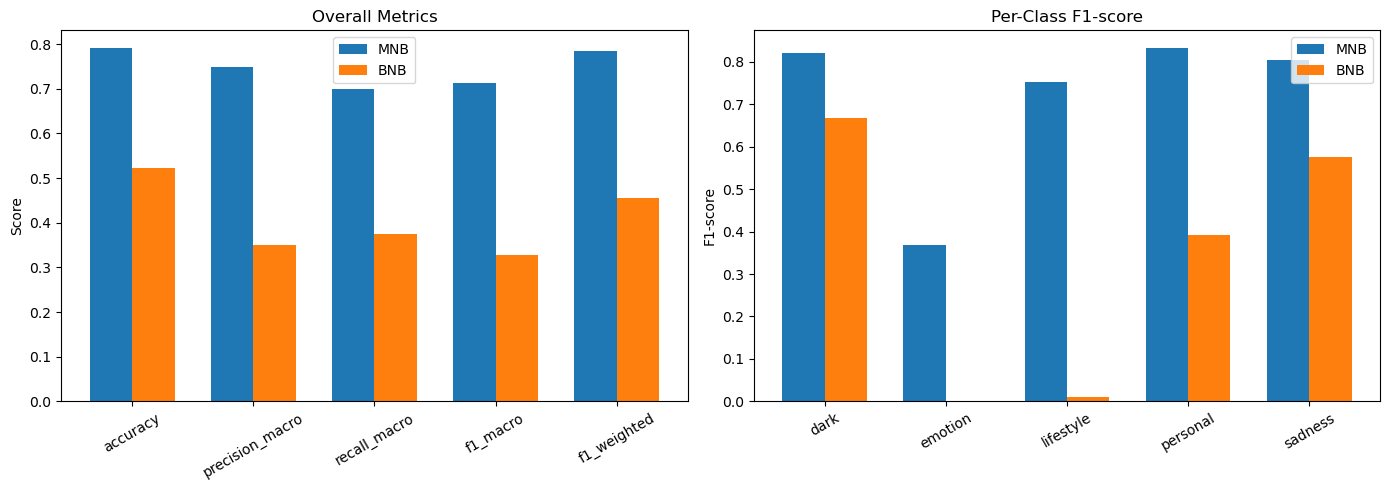

In [9]:
mnb_report = classification_report(y, y_pred_mnb, output_dict=True)
bnb_report = classification_report(y, y_pred_bnb, output_dict=True)
print(y)

categories = sorted(list(set(y)))

mnb_f1 = [mnb_report[c]['f1-score'] for c in categories]
bnb_f1 = [bnb_report[c]['f1-score'] for c in categories]

labels = scoring
x = np.arange(len(labels))
width = 0.35

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(x - width/2, mnb_score, width, label='MNB')
axes[0].bar(x + width/2, bnb_score, width, label='BNB')
axes[0].set_ylabel('Score')
axes[0].set_title('Overall Metrics')
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels, rotation=30)
axes[0].legend()

cat_x = np.arange(len(categories))
axes[1].bar(cat_x - width/2, mnb_f1, width, label='MNB')
axes[1].bar(cat_x + width/2, bnb_f1, width, label='BNB')
axes[1].set_ylabel('F1-score')
axes[1].set_title('Per-Class F1-score')
axes[1].set_xticks(cat_x)
axes[1].set_xticklabels(categories, rotation=30)
axes[1].legend()

plt.tight_layout()
plt.show()


Based on the optimal text preprocessing strategy (from Part 1.2), I compare the performance of MNB and BNB on the music topic classification task using five-fold cross validation. The evaluation metrics cover accuracy, precision, recall, and f1, including the macro average metric as well as the specific performance for each category.

Because of the serious imbalance of this dataset, it is more representative to use the global macro average metric to evaluate the model performance. In particular, F1 macro-average score, which integrates precision and recall, can effectively penalize the model for ignoring any class and prevent the model from focusing only on the large class at the expense of the small class.

The experimental results (see bar chart) show that MNB outperforms BNB by a large margin in all evaluation metrics, especially in the macro average metric. This shows that the BNB model is easy to ignore the minority class samples in the context of extremely unbalanced class distribution and high-dimensional text features. From the evaluation results of each category, all evaluation metrics of BNB on emotion category are 0, indicating that the model fails to identify any emotion sample during the whole cross-validation process, completely ignoring this minority class. In contrast, MNB not only has higher overall accuracy, but also has some discrimination ability for all classes, including those with fewer samples.



## Part 1.4 

In [10]:
N_list = [10,100, 300, 500, 1000, 1500, 2000, 3000, 4000, 5000, 7000, 10000]
k = 5
mnb_f1_list= []
bnb_f1_list= []

for N in N_list:
    vectorizer = CountVectorizer(max_features=N)
    X = vectorizer.fit_transform(df['Content_pro'])
    y = df['topic']

    mnb = MultinomialNB()
    bnb = BernoulliNB()

    mnb_f1 = cross_val_score(mnb, X, y, cv=k, scoring='f1_macro').mean()
    bnb_f1 = cross_val_score(bnb, X, y, cv=k, scoring='f1_macro').mean()
    mnb_f1_list.append(mnb_f1)
    bnb_f1_list.append(bnb_f1)
    print(f"N={N}, MNB f1: {mnb_f1:.4f}, BNB: {bnb_f1:.4f}")

best_mnb = np.argmax(mnb_f1_list)
best_bnb = np.argmax(bnb_f1_list)
best_N_mnb = N_list[best_mnb]
best_N_bnb = N_list[best_bnb]
print(f"MNB best N = {best_N_mnb}, f1_macro = {mnb_f1_list[best_mnb]:.4f}")
print(f"BNB best N = {best_N_bnb}, f1_macro = {bnb_f1_list[best_bnb]:.4f}")

N=10, MNB f1: 0.4294, BNB: 0.2961
N=100, MNB f1: 0.7177, BNB: 0.4894
N=300, MNB f1: 0.8433, BNB: 0.5384
N=500, MNB f1: 0.8455, BNB: 0.5588
N=1000, MNB f1: 0.8178, BNB: 0.5316
N=1500, MNB f1: 0.8026, BNB: 0.5020
N=2000, MNB f1: 0.7935, BNB: 0.4805
N=3000, MNB f1: 0.7841, BNB: 0.4472
N=4000, MNB f1: 0.7790, BNB: 0.4279
N=5000, MNB f1: 0.7715, BNB: 0.4008
N=7000, MNB f1: 0.7352, BNB: 0.3679
N=10000, MNB f1: 0.7138, BNB: 0.3286
MNB best N = 500, f1_macro = 0.8455
BNB best N = 500, f1_macro = 0.5588


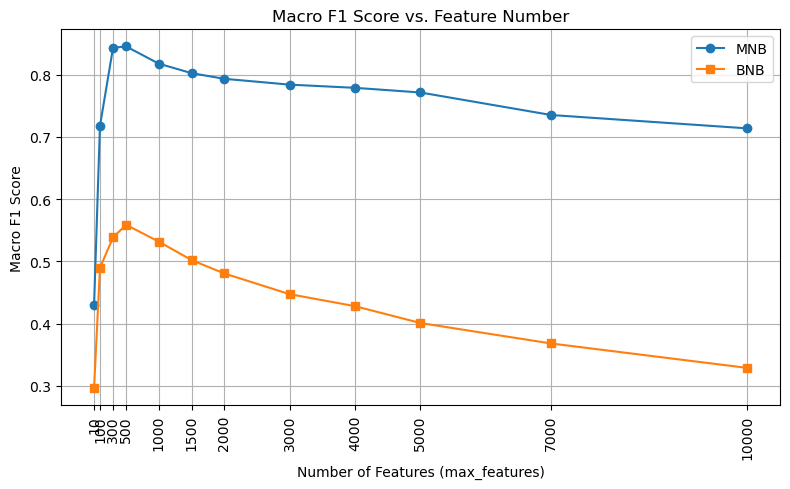

In [11]:
plt.figure(figsize=(8,5))
plt.plot(N_list, mnb_f1_list, marker='o', label='MNB')
plt.plot(N_list, bnb_f1_list, marker='s', label='BNB')
plt.xlabel('Number of Features (max_features)')
plt.ylabel('Macro F1 Score')
plt.title('Macro F1 Score vs. Feature Number')
plt.legend()
plt.grid(True)
plt.xticks(N_list, rotation=90)
plt.tight_layout()
plt.show()

In this part, I adopted different max_features parameters (only retaining the top N words with the highest word frequency) to extract features from the text, and compared the performance of the average F1 score of the BNB and MNB models. The experimental results are shown in the line graph. The F1 of BNB and MNB both increase initially as N increases, guiding N to around 500, and then gradually decrease as N increases. It indicates that in the current task, when N is approximately 500, the classification performance of the model is the best.

## Part 1.5
In this section, I adopt the Support Vector Machine (SVM) model for music theme classification. SVM is particularly suitable for high-dimensional data scenarios, such as text classification tasks, because it maximizes the intervals between different categories by finding the optimal separated hyperplane, effectively enhancing the generalization ability of the model. Our data is represented by high-dimensional sparse vectors composed of words, which is exactly the type that SVM is good at handling.

In addition, Saigal et al. analyzed the performance of various SVM variants in Multi-category text classification in the paper "Multi-category news classification using Support Vector Machine based classifiers". The results show that the effect of SVM on the 20 Newsgroups dataset is particularly prominent. 20 Newsgroups is a classic high-dimensional sparse text classification task and has a high similarity with this project. Therefore, SVM is expected to achieve good performance in this task and is expected to achieve higher overall classification performance than BNB in this task. However, since MNB is good at multiple distributions and has strong performance in classification tasks, the improvement range of SVM may be limited

In [12]:
vectorizer = CountVectorizer(max_features=500)
X = vectorizer.fit_transform(df['Content_pro'])
y = df['topic']

svm = LinearSVC(max_iter=3000)  

k = 5
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'f1_weighted']
svm_results_N500 = cross_validate(svm, X, y, cv=k, scoring=scoring)

for s in scoring:
    print(f"SVM with N = 500 {s}: {svm_results_N500['test_'+s].mean():.4f}")

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['Content_pro'])

svm = LinearSVC(max_iter=3000)  

svm_results = cross_validate(svm, X, y, cv=k, scoring=scoring)

for s in scoring:
    print(f"SVM with N = max {s}: {svm_results['test_'+s].mean():.4f}")

SVM with N = 500 accuracy: 0.8365
SVM with N = 500 precision_macro: 0.8099
SVM with N = 500 recall_macro: 0.7976
SVM with N = 500 f1_macro: 0.8020
SVM with N = 500 f1_weighted: 0.8354
SVM with N = max accuracy: 0.8547
SVM with N = max precision_macro: 0.8398
SVM with N = max recall_macro: 0.8087
SVM with N = max f1_macro: 0.8208
SVM with N = max f1_weighted: 0.8531


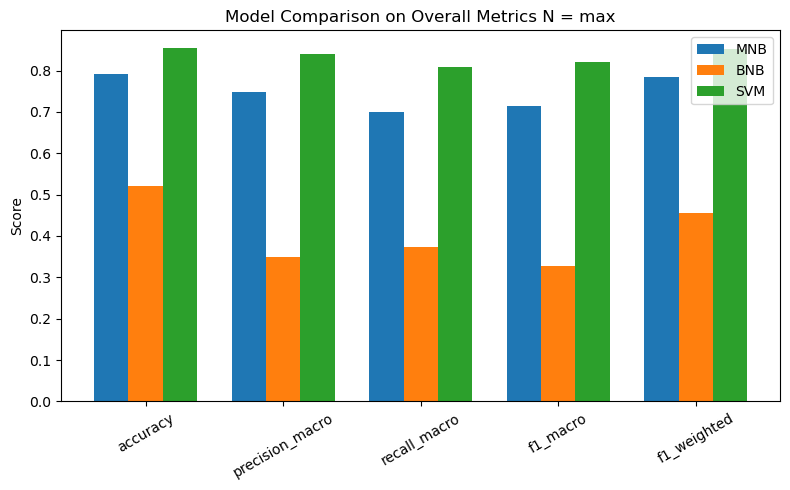

In [13]:
svm_score = [svm_results['test_' + m].mean() for m in scoring]

labels = scoring
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width, mnb_score, width, label='MNB')
rects2 = ax.bar(x, bnb_score, width, label='BNB')
rects3 = ax.bar(x + width, svm_score, width, label='SVM')

ax.set_ylabel('Score')
ax.set_title('Model Comparison on Overall Metrics N = max')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=30)
ax.legend()

plt.tight_layout()
plt.show()

# Part 2
## Part 2.1

In [14]:
# model from Part 1
N=500
vectorizer = CountVectorizer(max_features=N)
X = vectorizer.fit_transform(df['Content_pro'])
y = df['topic']

mnb = MultinomialNB()
mnb.fit(X, y)

predicted_topics = mnb.predict(X)
df['predicted_topic'] = predicted_topics
df

,Content,topic,Content_pro,predicted_topic
0,loving the not real lake 2016 rock awake know ...,dark,loving the not real lake 2016 rock awake know ...,dark
1,incubus into the summer 2019 rock shouldn summ...,lifestyle,incubus into the summer 2019 rock shouldn summ...,lifestyle
2,reignwolf hardcore 2016 blues lose deep catch ...,sadness,reignwolf hardcore 2016 blue lose deep catch b...,sadness
3,tedeschi trucks band anyhow 2016 blues run bit...,sadness,tedeschi truck band anyhow 2016 blue run bitte...,sadness
4,lukas nelson and promise of the real if i star...,dark,lukas nelson and promise of the real if i star...,dark
...,...,...,...,...
1495,ra ra riot absolutely 2016 rock year absolutel...,emotion,ra ra riot absolutely 2016 rock year absolutel...,emotion
1496,mat kearney face to face 2018 rock breakthroug...,dark,mat kearney face to face 2018 rock breakthroug...,dark
1497,owane born in space 2018 jazz look look right ...,dark,owane born in space 2018 jazz look look right ...,dark
1498,nappy roots blowin' trees 2019 hip hop nappy r...,personal,nappy root blowin tree 2019 hip hop nappy root...,personal


In [15]:
# Create tf-idf matrixs
train_data = df.iloc[:750]
topic_c = df['predicted_topic'].unique()
matrices=[]
vectorizers={}
for t in topic_c:
    topic_doc=train_data[train_data['predicted_topic'] == t]['Content']
    vectorizer = TfidfVectorizer()
    vectorizer.fit(topic_doc)
    X=vectorizer.transform(topic_doc)
    vectorizers[t] = vectorizer
    matrices.append(X)
print(topic_c[0],matrices[0].shape,topic_c[1],matrices[1].shape,topic_c[2],matrices[2].shape,topic_c[3],matrices[3].shape,topic_c[4],matrices[4].shape)

dark (244, 4101) lifestyle (93, 1527) sadness (188, 2280) emotion (42, 876) personal (183, 2919)


In [16]:
user_keywords = []

for user in [1, 2]:
    with open(f'user{user}.tsv', 'r', encoding='utf-8') as f:
        lines = f.readlines()
        theme_keywords = []
        for l in lines:
            keywords = [i.strip().lower() for i in l.strip().split('\t') if i.strip()]
            theme_keywords.append(keywords)
        user_keywords.append(theme_keywords[1:]) 

print("User 1:",user_keywords[0], "\nUser 2:", user_keywords[1])

User 1: [['dark', 'fire, enemy, pain, storm, fight'], ['sadness', 'cry, alone, heartbroken, tears, regret'], ['personal', 'dream, truth, life, growth, identity'], ['lifestyle', 'party, city, night, light, rhythm'], ['emotion', 'love, memory, hug, kiss, feel']] 
User 2: [['sadness', 'lost, sorrow, goodbye, tears, silence'], ['emotion', 'romance, touch, feeling, kiss, memory']]


In [17]:
user_1_like=[]
user_2_like=[]

for word in user_keywords[0]:
    topic=word[0]
    key=[w.strip() for w in word[1].split(',')]
    df_match_topic=train_data[(train_data['predicted_topic'] == topic) & train_data['Content_pro'].apply(lambda x: any(i in x for i in key))]['Content']
    user_1_like.append(df_match_topic)

for word in user_keywords[1]:
    topic=word[0]
    key=[w.strip() for w in word[1].split(',')]
    df_match_topic=train_data[(train_data['predicted_topic'] == topic) & train_data['Content_pro'].apply(lambda x: any(i in x for i in key))]['Content']
    user_2_like.append(df_match_topic)
user_2_like[1]

5      tia ray just my luck 2018 jazz yeah happen rea...
34     cody johnson kiss goodbye 2016 country slide i...
56     tori kelly i was made for loving you 2016 pop ...
248    the struts kiss this 2016 rock say stay home a...
327    t-rock 4:20/reincarnated 2016 hip hop feel fee...
364    311 good feeling 2019 reggae look look time su...
412    esperanza spalding touch in mine (fingers) 201...
423    jd mcpherson on the lips 2017 blues dream like...
448    sufjan stevens visions of gideon 2017 rock lov...
484    gregory porter holding on 2016 jazz weight sho...
541    kbong good lovin 2017 reggae good good good lo...
579    shag rock lip addiction 2017 reggae tonight ru...
633    twenty one pilots cancer 2016 rock turn away d...
728    kelly clarkson love so soft 2017 pop kiss door...
741    weldon irvine morning sunrise 2016 jazz mornin...
Name: Content, dtype: object

In [18]:
user_1_vector=[]
print("User 1 Profiles =====================================")
for i in range(len(user_1_like)):
    vectorizer = vectorizers[user_keywords[0][i][0]]
    X = vectorizer.transform([' '.join(user_1_like[i])])
    user_1_vector.append(X)
    feature_names = np.array(vectorizer.get_feature_names_out())
    tfidf_weights = X.toarray()[0]
    top_indices = tfidf_weights.argsort()[::-1][:20]
    top_words = feature_names[top_indices]
    print("=============",user_keywords[0][i][0],"=============")
    print(top_words)

User 1 Profiles =====================================
============= dark =============
['fight' 'like' 'know' 'black' 'grind' 'blood' 'stand' 'come' 'yeah'
 'tell' 'gonna' 'kill' 'hand' 'cause' 'lanky' 'dilly' 'head' 'follow'
 'good' 'time']
============= sadness =============
['cry' 'club' 'steal' 'tear' 'wish' 'lay' 'mean' 'know' 'baby' 'music'
 'write' 'smile' 'say' 'true' 'think' 'face' 'hand' 'regret' 'eye'
 'greater']
============= personal =============
['life' 'live' 'change' 'world' 'know' 'yeah' 'dream' 'wanna' 'like'
 'thank' 'teach' 'lord' 'come' 'time' 'beat' 'think' 'learn' 'need' 'go'
 'right']
============= lifestyle =============
['tonight' 'night' 'come' 'home' 'closer' 'time' 'strangers' 'song' 'sing'
 'long' 'wait' 'wanna' 'spoil' 'tire' 'right' 'struggle' 'yeah' 'play'
 'mind' 'like']
============= emotion =============
['good' 'touch' 'feel' 'hold' 'know' 'morning' 'video' 'visions' 'loove'
 'kiss' 'vibe' 'feelin' 'want' 'go' 'miss' 'luck' 'sunrise' 'love' 'lovin'

In [19]:
print("User 2 Profiles =====================================")
user_2_vector=[]
for i in range(len(user_2_like)):
    vectorizer = vectorizers[user_keywords[1][i][0]]
    X = vectorizer.transform([' '.join(user_2_like[i])])
    user_2_vector.append(X)
    feature_names = np.array(vectorizer.get_feature_names_out())
    tfidf_weights = X.toarray()[0]
    top_indices = tfidf_weights.argsort()[::-1][:20]
    top_words = feature_names[top_indices]
    print("=============",user_keywords[1][i][0],"=============")
    print(top_words)

User 2 Profiles =====================================
============= sadness =============
['inside' 'break' 'heart' 'step' 'away' 'goodbye' 'violence' 'rainwater'
 'fade' 'blame' 'like' 'hard' 'leave' 'scar' 'open' 'fall' 'magnify' 'go'
 'smile' 'time']
============= emotion =============
['touch' 'good' 'video' 'visions' 'loove' 'kiss' 'hold' 'morning' 'feelin'
 'luck' 'sunrise' 'lovin' 'gimme' 'lips' 'look' 'know' 'time' 'feel'
 'cause' 'addiction']


The profiles of user1 and user2 are shown above. The high-weight words in the user profiles are basically consistent with the originally set interest keywords. The portrait directly contains some user interest words. Furthermore, words such as 'fight', 'black', and 'blood' under the 'dark' theme, and 'feel' and 'baby' under the 'emotion' theme are also highly relevant to the corresponding themes. A small number of words such as "like", "know", "time", "yeah", and "na" are common lyrics conjunctions or colloquial expressions. Overall, the user portraits screened out by the recommendation system through interest keywords can better reflect the interest directions of users under different topics, demonstrating the rationality of the recommendation algorithm in simulating user interests.

In [20]:
user3_keywords = [
    ['personal', 'hope, future, dream, learn, freedom'],
    ['lifestyle', 'travel, road, summer, sea, friend']
]

user_3_like=[]

for word in user3_keywords:
    topic=word[0]
    key=[w.strip() for w in word[1].split(',')]
    df_match_topic=train_data[(train_data['predicted_topic'] == topic) & train_data['Content_pro'].apply(lambda x: any(i in x for i in key))]['Content']
    user_3_like.append(df_match_topic)
    
print("User 3 Profiles =====================================")
user_3_vector=[]
for i in range(len(user_3_like)):
    vectorizer = vectorizers[user3_keywords[i][0]]
    X = vectorizer.transform([' '.join(user_3_like[i])])
    user_3_vector.append(X)
    feature_names = np.array(vectorizer.get_feature_names_out())
    tfidf_weights = X.toarray()[0]
    top_indices = tfidf_weights.argsort()[::-1][:20]
    top_words = feature_names[top_indices]
    print("=============",user3_keywords[i][0],"=============")
    print(top_words)

User 3 Profiles =====================================
============= personal =============
['thank' 'life' 'change' 'dream' 'world' 'yeah' 'learn' 'live' 'know'
 'come' 'wanna' 'automaton' 'like' 'everybody' 'time' 'cause' 'right'
 'gotta' 'think' 'feel']
============= lifestyle =============
['home' 'song' 'tonight' 'tire' 'come' 'sing' 'telephone' 'summer' 'ring'
 'lalala' 'revelator' 'songs' 'write' 'hallelujah' 'long' 'wait' 'yeah'
 'wanna' 'tell' 'oohoohooh']


The above are the keywords defined by User3, and the top 20 high-weight TF-IDF words under each topic are displayed. Similar to User1 and User2, most of the high-weight words in User3's profile can accurately reflect the interest directions it has set. Except for a few common lyric conjunctions or colloquial expressions, other words are highly relevant to the corresponding themes, indicating that the construction of user profiles still has good rationality.

## Part 2.2


In [21]:
def jaccard_similarity(a, b):
    if hasattr(a, 'toarray'):
        a = a.toarray()
    if hasattr(b, 'toarray'):
        b = b.toarray()
    a = np.asarray(a).ravel()
    b = np.asarray(b).ravel()
    intersection = np.logical_and(a > 0, b > 0).sum()
    union = np.logical_or(a > 0, b > 0).sum()
    return intersection / union if union > 0 else 0

def dice_similarity(a, b):
    if hasattr(a, 'toarray'):
        a = a.toarray()
    if hasattr(b, 'toarray'):
        b = b.toarray()
    a = np.asarray(a).ravel()
    b = np.asarray(b).ravel()
    intersection = np.logical_and(a > 0, b > 0).sum()
    total = (a > 0).sum() + (b > 0).sum()
    return 2 * intersection / total if total > 0 else 0


def rec(user_keywords,user_vector,N,M,method='cosine'):
    test_data_c=test_data.copy()
    topic_list = [topic_keywords[0] for topic_keywords in user_keywords]
    for idx,topic_keywords  in enumerate(user_keywords):
        
        topic = topic_keywords[0]
        topic_vec=user_vector[idx]
        vectorizer = vectorizers[topic]
        prof_weights = topic_vec.toarray()[0]
        
        if M<20:
            top_indices = prof_weights.argsort()[::-1][:M]
            topic_vec = np.zeros_like(prof_weights)
            topic_vec[top_indices] = prof_weights[top_indices]
            topic_vec = topic_vec.reshape(1, -1)
        
        
        test_vec = vectorizer.transform(test_data_c['Content'])
        
        if method == 'cosine':
            sims = cosine_similarity(test_vec, topic_vec).flatten()
        elif method == 'euclidean':
            dists = euclidean_distances(test_vec, topic_vec).flatten()
            sims = 1 / (1 + dists)  # 距离越小相似度越大
        elif method == 'jaccard':
            sims = []
            for i in range(test_vec.shape[0]):
                a = test_vec[i].toarray()[0]
                b = topic_vec[0]
                sims.append(jaccard_similarity(a, b))
            sims = np.array(sims)
        elif method == 'dice':
            sims = []
            for i in range(test_vec.shape[0]):
                a = test_vec[i].toarray()[0]
                b = topic_vec[0]
                sims.append(dice_similarity(a, b))
            sims = np.array(sims)
        else:
            raise ValueError(f"Unknown method: {method}")
        test_data_c[f'{topic}_sim_score'] = sims
        
    sim_cols = [f'{topic}_sim_score' for topic in topic_list]
    sim_matrix = test_data_c[sim_cols].values  # shape=(n_songs, n_topics)
    
    max_sim = sim_matrix.max(axis=1)
    max_sim_topic_idx = sim_matrix.argmax(axis=1)
    max_sim_topic = [topic_list[i] for i in max_sim_topic_idx]
    
    test_data_c['max_sim'] = max_sim
    test_data_c['max_sim_topic'] = max_sim_topic
    topN = test_data_c.nlargest(N, 'max_sim')[['Content','topic','predicted_topic','max_sim_topic']]
    
    liked = (topN['max_sim_topic'] == topN['predicted_topic'])
    true = liked.sum()
    
    user_interested_topics = set(topic_list)
    relevant_items = test_data_c[test_data_c['predicted_topic'].isin(user_interested_topics)]
    total_relevant = len(relevant_items)
    
    precision = true / N
    recall = true / total_relevant if total_relevant > 0 else 0
    f1 = 2 * precision * recall / (precision + recall)
    
    return precision,recall,f1,topN

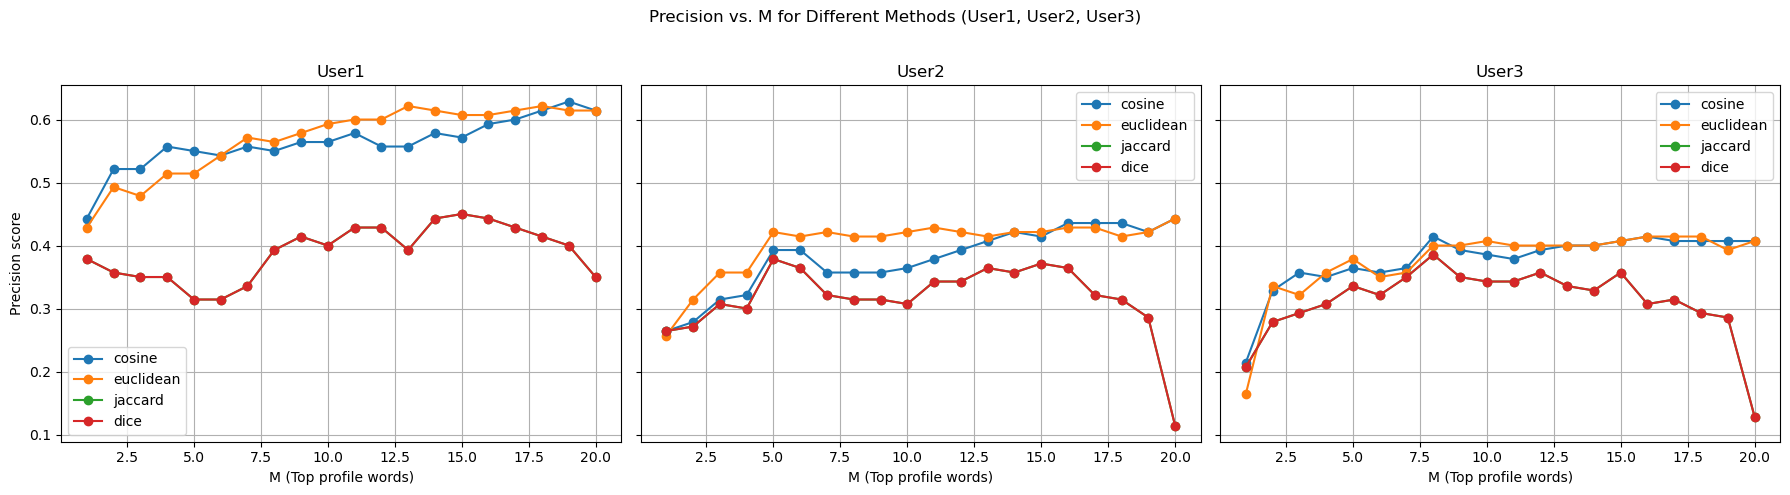

In [22]:
test_data = df.iloc[750:1000]

method=['cosine','euclidean','jaccard','dice']
N=[140]
M=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
best_f1 = 0
best_result = {}

plot_records = []

users = [
    (user_keywords[0], user_1_vector, "User1"),
    (user_keywords[1], user_2_vector, "User2"),
    (user3_keywords, user_3_vector, "User3")
]

best_precisions=[]

for u_keywords, u_vec, uname in users:
    best=0
    for meth in method:
        for n in N:
            for m in M:
                precision, recall, f1, topN = rec(u_keywords, u_vec, N=n, M=m, method=meth)
                plot_records.append({
                    'user': uname,
                    'method': meth,
                    'M': m,
                    'p': precision
                })
                if precision > best:
                    best=precision
    best_precisions.append(best)
    
df_plot = pd.DataFrame(plot_records)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, uname in enumerate(["User1", "User2", "User3"]):
    ax = axes[i]
    for meth in method:
        sub = df_plot[(df_plot['user'] == uname) & (df_plot['method'] == meth)]
        ax.plot(sub['M'], sub['p'], marker='o', label=meth)
    ax.set_title(uname)
    ax.set_xlabel('M (Top profile words)')
    if i == 0:
        ax.set_ylabel('Precision score')
    ax.legend()
    ax.grid(True)

fig.suptitle('Precision vs. M for Different Methods (User1, User2, User3)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

The experimental results are shown in the above line graph. I fixed N at 140 (assuming 20 songs are recommended every day, totaling 140 songs for a week), and recommended a total of N songs, the setting is more in line with the actual application scenarios (if there are no suitable new songs for a certain theme this week, the recommendations for that theme will not be displayed). The main evaluation metric of this experiment is Precision, because Recall and F1 will very vary with the choice of N and the number of interest topics in the user profile.

For User1, the effect of using cosine similarity matching is the best; For User2 and User3, both the Euclidean distance and cosine similarity have good performances. When the three users performed the best in Precision, the corresponding M values (the number of high-weight keywords retained in the portrait) were all around 17. It is worth noting that the Precision of User1 is significantly higher than that of User2 and User3. This is mainly because User1 has a richer and more comprehensive interest profile, thus ensuring higher accuracy in system push notifications.

Therefore, I chose M=17 and adopted cosine similarity as the matching method between the user profile and the song.

## Part 3

In [23]:
df = pd.read_csv('dataset.tsv', sep='\t')
df

,artist_name,track_name,release_date,genre,lyrics,topic
0,loving,the not real lake,2016,rock,awake know go see time clear world mirror worl...,dark
1,incubus,into the summer,2019,rock,shouldn summer pretty build spill ready overfl...,lifestyle
2,reignwolf,hardcore,2016,blues,lose deep catch breath think say try break wal...,sadness
3,tedeschi trucks band,anyhow,2016,blues,run bitter taste take rest feel anchor soul pl...,sadness
4,lukas nelson and promise of the real,if i started over,2017,blues,think think different set apart sober mind sym...,dark
...,...,...,...,...,...,...
1495,ra ra riot,absolutely,2016,rock,year absolutely absolutely absolutely crush ab...,emotion
1496,mat kearney,face to face,2018,rock,breakthrough hours hear truth moments trade fa...,dark
1497,owane,born in space,2018,jazz,look look right catch blue eye own state breat...,dark
1498,nappy roots,blowin' trees,2019,hip hop,nappy root gotta alright flyin dear leave lone...,personal


In [24]:
df['Content'] = (
    df['artist_name'].astype(str) + ' ' +
    df['track_name'].astype(str) + ' ' +
    df['release_date'].astype(str) + ' ' +
    df['genre'].astype(str) + ' ' +
    df['lyrics'].astype(str)
)
df = df[['Content', 'topic']]

df['Content_pro'] = df['Content'].apply(lambda x: 
    preprocess_text(x, remove_special_chars=True, regex=r"[^\w\s]", strategy='remove',
                    lowercase=True, stp=False, stemming='lemma')
)

train_data = df.iloc[:750]
test_data = df.iloc[750:1000]

N=500
vectorizer = CountVectorizer(max_features=N)
X = vectorizer.fit_transform(train_data['Content_pro'])
y = train_data['topic']

mnb = MultinomialNB()
mnb.fit(X, y)

C:\Users\Aufb\AppData\Local\Temp\ipykernel_30328\2049205918.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Content_pro'] = df['Content'].apply(lambda x:


MultinomialNB()

In [25]:
user_record_idx=[5,7,12,37,54,55,59,48,71,72,77,79,87,88,95,96,116,101,127,256,274,278,296,299,317,324,357,550,552,569,619,614,636,641]
user_likes = df.loc[user_record_idx, ['Content_pro']].copy()

X_pre = vectorizer.fit_transform(user_likes['Content_pro'])
predicted_topics = mnb.predict(X_pre)
user_likes['predicted_topic'] = predicted_topics
user_likes

,Content_pro,predicted_topic
5,tia ray just my luck 2018 jazz yeah happen rea...,sadness
7,thank you scientist the amateur arsonist handb...,dark
12,devin townsend project truth 2016 jazz warn mo...,dark
37,black pistol fire hard luck 2016 blue cold smo...,lifestyle
54,anderson east without you 2018 blue dark live ...,dark
55,keb mo this is my home 2019 blue lupe come mex...,dark
59,taylor mcferrin memory digital 2019 jazz want ...,dark
48,the dear hunter the fire remains 2016 jazz lon...,dark
71,abstract orchestra new day 2018 jazz slide was...,lifestyle
72,wax tailor ecstasy 2017 jazz lock away thing h...,dark


In [26]:
user_like_pertpioc = []
user_topic=user_likes['predicted_topic'].unique()
for t in user_topic:
    user_like_pertpioc.append( user_likes[user_likes['predicted_topic'] == t]['Content_pro']) 
print(user_topic,len(user_like_pertpioc[0]),len(user_like_pertpioc[1]),len(user_like_pertpioc[2]),len(user_like_pertpioc[3]),len(user_like_pertpioc[4]))

['sadness' 'dark' 'lifestyle' 'personal' 'emotion'] 6 14 6 6 2


In [27]:
user_3_vector=[]
for i in range(len(user_like_pertpioc)):
    vectorizer = vectorizers[user_topic[i]]
    X = vectorizer.transform([' '.join(user_like_pertpioc[i])])
    user_3_vector.append(X)
print(user_3_vector[0].shape,user_3_vector[1].shape,user_3_vector[2].shape,user_3_vector[3].shape,user_3_vector[4].shape)

(1, 2280) (1, 4101) (1, 1527) (1, 2919) (1, 876)


In [28]:
test_data_c=test_data.copy()

M=17
N=140
for idx,topic_vec  in enumerate(user_3_vector):    
    topic = user_topic[idx]
    vectorizer = vectorizers[topic]
    prof_weights = topic_vec.toarray()[0]
        
    top_indices = prof_weights.argsort()[::-1][:M]
    topic_vec = np.zeros_like(prof_weights)
    topic_vec[top_indices] = prof_weights[top_indices]
    topic_vec = topic_vec.reshape(1, -1)
        
    test_vec = vectorizer.transform(test_data_c['Content'])
    sims = cosine_similarity(test_vec, topic_vec).flatten()
    test_data_c[f'{topic}_sim_score'] = sims
        
sim_cols = [f'{topic}_sim_score' for topic in user_topic]
sim_matrix = test_data_c[sim_cols].values 
    
max_sim = sim_matrix.max(axis=1)
max_sim_topic_idx = sim_matrix.argmax(axis=1)
max_sim_topic = [user_topic[i] for i in max_sim_topic_idx]
    
test_data_c['max_sim'] = max_sim
test_data_c['max_sim_topic'] = max_sim_topic
topN = test_data_c.nlargest(N, 'max_sim')[['Content','topic']]

In [29]:
topN

,Content,topic
907,harry styles sign of the times 2017 pop stop c...,sadness
848,kehlani feels 2019 pop real contemplate bout ...,emotion
755,gary hoey boxcar blues 2016 blues boxcar blue ...,lifestyle
765,iya terra follow your heart (feat. zion thomps...,personal
975,thank you scientist swarm 2019 jazz circle ret...,sadness
...,...,...
815,palace live well 2016 rock sundown slow remind...,personal
997,tesseract smile 2018 jazz calm soothe mechanic...,sadness
998,godsmack under your scars 2018 rock sense thin...,dark
895,he is we i wouldn't mind 2017 rock fall line l...,lifestyle


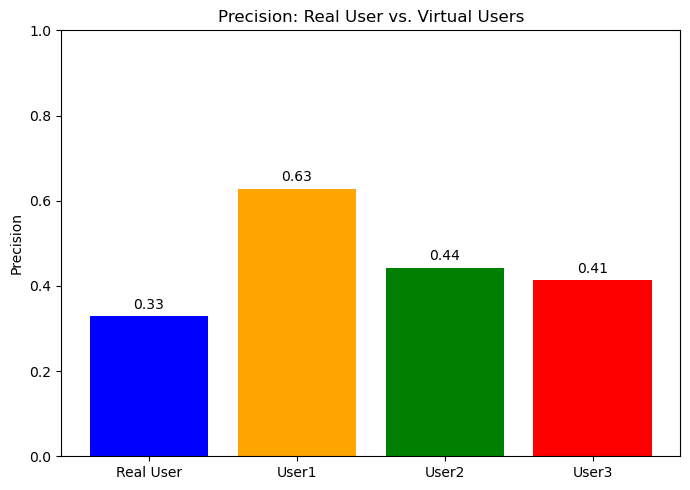

In [30]:
user_like_test=[755,975,794,851,942,790,981,913,864,945,806,862,781,830,840,846,925,916,896,822,885,883,987,882,789,791,985,899,894,964,831,891,993,892,978,783,774,855,958,888,812,784,847,887,965,997]
precision = len(user_like_test) / N

all_precisions = [precision] + best_precisions
labels = ['Real User', 'User1', 'User2', 'User3']
x = np.arange(len(labels))

plt.figure(figsize=(7,5))
bars = plt.bar(x, all_precisions, color=['blue', 'orange', 'green', 'red'])

# 标数值
for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2., height + 0.01, 
             f'{height:.2f}', ha='center', va='bottom')

plt.ylim(0, 1)
plt.ylabel('Precision')
plt.title('Precision: Real User vs. Virtual Users')
plt.xticks(x, labels)
plt.tight_layout()
plt.show()

I invited a friend who has no knowledge of recommendation systems to participate in this user experiment. During the first three weeks, 140 songs were pushed each week, and the user selected a total of 34 songs that he liked.

The bar chart above compares the Precision metrics of real users and three virtual users. It can be seen that the Precision of real users is significantly lower than that of virtual users. This is mainly because when this user selects the songs he like, he pay more attention to the music types (such as Jazz and Blues) rather than the hashtags. Therefore, the matching degree of the recommendation model constructed based on topic classification for this user is lower than that for the virtual user designed by topic interests.

However, user feedback indicated that, some of the songs pushed still met his taste, and he was overall satisfied with the recommendation results. This indicates that our model has certain generalization ability and robustness, and can provide certain personalized recommendations for users beyond the thematic interests. At the same time, he also discovered that our recommendation system pays more attention to the theme of music rather than the type of music.